In [1]:
from cycada_utils import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'On {device}')

Figure directory exists.
On cuda:0


In [2]:
class CyDataset(Dataset):
    def __init__(self):

        self.D = []
        self.L = []
                
        with open('/datacommons/carlsonlab/srs108/old/ol/Delhi_labeled.pkl', "rb") as fp:
            for station in pkl.load(fp):
#                 if station['PM25'] <600:
                self.D.append(tuple((station['Image'][:,:,:3], station['PM25'])))
                
        with open('/datacommons/carlsonlab/srs108/old/ol/Lucknow.pkl', "rb") as fp:
            for station in pkl.load(fp):
                for datapoint in station:
                    luck_img = datapoint['Image'][:,:,:3]
                    if luck_img.shape == (224, 224,3):  
                        self.L.append(tuple((luck_img, datapoint['PM'])))
                        
        self.L = random.choices(self.L, k= len(self.D))
        
    def __len__(self): return (len(self.D))
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        transform  = transforms.Compose([
                            transforms.ToPILImage(),
                            transforms.RandomHorizontalFlip(),
                            transforms.RandomVerticalFlip(),
                            transforms.ToTensor()])

        d_img = self.D[idx][0]
        d_img = transform(d_img)        
        l_img = self.L[idx][0]
        l_img = transform(l_img)
        
        sample = {
              'D img': d_img,
              'D pm' : torch.tensor(self.D[idx][1]),
              'L img': l_img,
              'L pm' : torch.tensor(self.L[idx][1])
        }
        return sample

In [3]:
tr = CyDataset()
train, val = train_test_split(tr, test_size=0.2, random_state=42)
train_dataloader = DataLoader(
    train,
    batch_size=5, # 1
    shuffle=True)

val_dataloader = DataLoader(
    val,
    batch_size=1, # 1
    shuffle=True)

In [4]:
norm_layer = functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)
G_ST = ResnetGenerator(3, 3, 64, norm_layer=norm_layer, use_dropout=False, n_blocks=2)
G_TS = ResnetGenerator(3, 3, 64, norm_layer=norm_layer, use_dropout=False, n_blocks=2)

D_T = NLayerDiscriminator(3)
D_S = NLayerDiscriminator(3)
f_s = Multi_City_CNN()
f_s.load_state_dict(torch.load('dlm4.pt'))

G_ST.to(device)
G_TS.to(device)
D_S.to(device)
D_T.to(device)
f_s.to(device)


ganloss = GANLoss().to(device)                         #use to fool discriminator
cycleloss = torch.nn.L1Loss().to(device)               #difference between reconstructed img and original
mseloss = torch.nn.MSELoss().to(device)       #difference between domain classifications between input img and generator output

optimizer_G = torch.optim.Adam(itertools.chain(G_ST.parameters(), G_TS.parameters()), lr=2e-4, betas=(0.5,0.999))
optimizer_D = torch.optim.Adam(itertools.chain(D_S.parameters(), D_T.parameters()), lr=1e-5, betas=(0.5, 0.999))
optimizer_f_s = torch.optim.Adam(f_s.parameters(), lr=1e-4, betas=(0.5, 0.999))    


G_ST.apply(weights_init_normal)
G_TS.apply(weights_init_normal)
D_S.apply(weights_init_normal)
D_T.apply(weights_init_normal)
print()

In [5]:
def sample_images(dataloader, e, i, save=False):

    source = next(iter(dataloader))
    G_ST.eval()
    G_TS.eval()
    real_source = source['D img'].type(Tensor) 
    fake_target = G_ST(real_source).detach()
    real_target = source['L img'].type(Tensor)
    real_lbl= source['D pm'].type(Tensor).float()
    fake_source = G_TS(real_target).detach()
    
    recons = G_TS(fake_target).detach()
    recont = G_ST(fake_source).detach() 

    real_S = make_grid(real_source, nrow=5, normalize=True, scale_each=True, padding=1)
    fake_T = make_grid(fake_target, nrow=5, normalize=True, scale_each=True, padding=1)
    reconS = make_grid(recons, nrow=5, normalize=True, scale_each=True, padding=1)
    real_T = make_grid(real_target, nrow=5, normalize=True, scale_each=True, padding=1)
    fake_S = make_grid(fake_source, nrow=5, normalize=True, scale_each=True, padding=1)
    reconT = make_grid(recont, nrow=5, normalize=True, scale_each=True, padding=1)
    # Arange images along y-axis    
    image_grid = torch.cat((real_S, fake_T, real_T, fake_S, reconS, reconT), 2)
    plt.imshow(image_grid.cpu().permute(1,2,0))
    plt.title('Real Source vs Fake Target vs Recon Source | Real Target vs Fake Source vs Recon Target')
    plt.axis('off')
    plt.gcf().set_size_inches(10, 6)
    if save:
        plt.savefig(os.path.join('Figure_PDFs', f'epoch_{str(e+1)}_iter{str(i+1)}.png'), bbox_inches='tight', pad_inches=0, facecolor='white')
    plt.show();

loss source: 1.7399497032165527
loss target: 1.6034235954284668
loss source: 1.6793794631958008
loss target: 1.6111595630645752
loss source: 1.6817799806594849
loss target: 1.597517490386963
loss source: 1.5795996189117432
loss target: 1.5924441814422607
loss source: 1.6432167291641235
loss target: 1.560014009475708
loss source: 1.5591636896133423
loss target: 1.4825834035873413
loss source: 1.567201852798462
loss target: 1.5308940410614014
loss source: 1.4490675926208496
loss target: 1.471013069152832
loss source: 1.4404826164245605
loss target: 1.4536564350128174
loss source: 1.321439504623413
loss target: 1.4650135040283203
loss source: 1.4146251678466797
loss target: 1.4606611728668213
loss source: 1.4239342212677002
loss target: 1.4564533233642578
loss source: 1.4687340259552002
loss target: 1.4025394916534424
loss source: 1.2895227670669556
loss target: 1.3989076614379883
loss source: 1.3422154188156128
loss target: 1.3159141540527344
loss source: 1.3596587181091309
loss target: 

loss source: 0.3121405839920044
loss target: 0.31453782320022583
loss source: 0.3010637164115906
loss target: 0.2897469699382782
loss source: 0.29695507884025574
loss target: 0.17961907386779785
loss source: 0.6482398509979248
loss target: 0.30389854311943054
loss source: 0.37489622831344604
loss target: 0.30667465925216675
loss source: 0.4483640789985657
loss target: 0.23830989003181458
loss source: 0.32974979281425476
loss target: 0.2690187096595764
loss source: 0.3819468319416046
loss target: 0.21930238604545593
loss source: 0.437610924243927
loss target: 0.2759897708892822
loss source: 0.49453872442245483
loss target: 0.2519678771495819
loss source: 0.400734007358551
loss target: 0.2563939392566681
loss source: 0.2246040403842926
loss target: 0.2035163938999176
loss source: 0.26632001996040344
loss target: 0.20646043121814728
loss source: 0.3649255633354187
loss target: 0.2959807515144348
loss source: 0.4185662269592285
loss target: 0.19485266506671906
loss source: 0.34350132942199

loss source: 0.2893469035625458
loss target: 0.06772154569625854
loss source: 0.10784319043159485
loss target: 0.057339850813150406
loss source: 0.16439414024353027
loss target: 0.06788048148155212
loss source: 0.16214382648468018
loss target: 0.0631457269191742
loss source: 0.21373251080513
loss target: 0.07715259492397308
loss source: 0.11406992375850677
loss target: 0.048433322459459305
loss source: 0.15067589282989502
loss target: 0.15283122658729553
loss source: 0.12050986289978027
loss target: 0.07890014350414276
loss source: 0.09783774614334106
loss target: 0.03862759470939636
loss source: 0.13808979094028473
loss target: 0.0602920800447464
loss source: 0.24884501099586487
loss target: 0.0949062630534172
loss source: 0.1143588274717331
loss target: 0.06679247319698334
loss source: 0.17257077991962433
loss target: 0.07276783883571625
loss source: 0.18789896368980408
loss target: 0.04887350648641586
loss source: 0.09486301243305206
loss target: 0.07547980546951294
loss source: 0.2

loss source: 0.052615195512771606
loss target: 0.03273940086364746
loss source: 0.13757887482643127
loss target: 0.02862466126680374
loss source: 0.09822125732898712
loss target: 0.043280068784952164
loss source: 0.04783066362142563
loss target: 0.023972678929567337
loss source: 0.17344063520431519
loss target: 0.06297686696052551
loss source: 0.09311230480670929
loss target: 0.030125100165605545
loss source: 0.18287254869937897
loss target: 0.034689899533987045
loss source: 0.08715271949768066
loss target: 0.05811530351638794
loss source: 0.1260615438222885
loss target: 0.04723399505019188
loss source: 0.07505138218402863
loss target: 0.029756076633930206
loss source: 0.1533699631690979
loss target: 0.03882370889186859
loss source: 0.1391451209783554
loss target: 0.03726273030042648
loss source: 0.18060387670993805
loss target: 0.06372480094432831
loss source: 0.2651289403438568
loss target: 0.04687224701046944
loss source: 0.07113045454025269
loss target: 0.0450064092874527
loss sour

loss source: 0.030705180019140244
loss target: 0.036700718104839325
loss source: 0.03732427954673767
loss target: 0.025576921179890633
loss source: 0.07182906568050385
loss target: 0.023967448621988297
loss source: 0.05138231813907623
loss target: 0.015613885596394539
loss source: 0.04813344031572342
loss target: 0.03888310119509697
loss source: 0.043902814388275146
loss target: 0.047592803835868835
loss source: 0.07820042967796326
loss target: 0.03811834752559662
loss source: 0.10400281846523285
loss target: 0.014875450171530247
loss source: 0.061907246708869934
loss target: 0.01847079209983349
loss source: 0.07895992696285248
loss target: 0.0218465905636549
loss source: 0.05165571719408035
loss target: 0.020922182127833366
loss source: 0.09256671369075775
loss target: 0.03172364458441734
loss source: 0.046950746327638626
loss target: 0.02743734046816826
loss source: 0.056632332503795624
loss target: 0.013424521312117577
loss source: 0.04481371119618416
loss target: 0.0186781883239746

loss source: 0.02091231755912304
loss target: 0.01821790263056755
loss source: 0.2164124995470047
loss target: 0.02103308215737343
loss source: 0.08082626760005951
loss target: 0.017145203426480293
loss source: 0.21793898940086365
loss target: 0.023516207933425903
loss source: 0.03753329813480377
loss target: 0.04131088778376579
loss source: 0.05261603370308876
loss target: 0.02278350293636322
loss source: 0.03676515445113182
loss target: 0.031515903770923615
loss source: 0.029592834413051605
loss target: 0.01620030589401722
loss source: 0.039565496146678925
loss target: 0.014421466737985611
loss source: 0.02952350489795208
loss target: 0.016981247812509537
loss source: 0.046329885721206665
loss target: 0.026848118752241135
loss source: 0.07888446003198624
loss target: 0.015746116638183594
loss source: 0.031074389815330505
loss target: 0.024039531126618385
loss source: 0.037274423986673355
loss target: 0.012845085002481937
loss source: 0.025432705879211426
loss target: 0.01566451415419

loss source: 0.10104838013648987
loss target: 0.02610715478658676
loss source: 0.03609994053840637
loss target: 0.01633707620203495
loss source: 0.031101660802960396
loss target: 0.015614467673003674
loss source: 0.017372624948620796
loss target: 0.01394242886453867
loss source: 0.15645228326320648
loss target: 0.017247231677174568
loss source: 0.06318282335996628
loss target: 0.015132348984479904
loss source: 0.04536348581314087
loss target: 0.0344335101544857
loss source: 0.04787162318825722
loss target: 0.009903443977236748
loss source: 0.05363528057932854
loss target: 0.010630734264850616
loss source: 0.05416232720017433
loss target: 0.015099984593689442
loss source: 0.04361448809504509
loss target: 0.01378351915627718
loss source: 0.019243087619543076
loss target: 0.012169606983661652
loss source: 0.1078174039721489
loss target: 0.01829194277524948
loss source: 0.018681485205888748
loss target: 0.011474266648292542
loss source: 0.03335289657115936
loss target: 0.013023421168327332

loss source: 0.07858611643314362
loss target: 0.006467726081609726
loss source: 0.022612396627664566
loss target: 0.01638796366751194
loss source: 0.023123547434806824
loss target: 0.02612057700753212
loss source: 0.06311913579702377
loss target: 0.0175706185400486
loss source: 0.15178382396697998
loss target: 0.04448399320244789
loss source: 0.22741779685020447
loss target: 0.018916405737400055
loss source: 0.04696957767009735
loss target: 0.012783113867044449
loss source: 0.05183599144220352
loss target: 0.019523747265338898
loss source: 0.060708917677402496
loss target: 0.012925288639962673
loss source: 0.03991137444972992
loss target: 0.008660180494189262
loss source: 0.01991148479282856
loss target: 0.026820866391062737
loss source: 0.15419162809848785
loss target: 0.017537513747811317
loss source: 0.028752580285072327
loss target: 0.03918939083814621
loss source: 0.03655563294887543
loss target: 0.012858076021075249
loss source: 0.0791945606470108
loss target: 0.01179254055023193

loss source: 0.016211476176977158
loss target: 0.013179825618863106
loss source: 0.013464788906276226
loss target: 0.010629304684698582
loss source: 0.022532645612955093
loss target: 0.009447713382542133
loss source: 0.007682345807552338
loss target: 0.007045078091323376
loss source: 0.01881117932498455
loss target: 0.019777661189436913
loss source: 0.023375554010272026
loss target: 0.013082277961075306
loss source: 0.04242748022079468
loss target: 0.013406606391072273
loss source: 0.018236316740512848
loss target: 0.009651240892708302
loss source: 0.013389522209763527
loss target: 0.017959553748369217
loss source: 0.025218835100531578
loss target: 0.03883356973528862
loss source: 0.012147244065999985
loss target: 0.014321209862828255
loss source: 0.01075214333832264
loss target: 0.010896315798163414
loss source: 0.017904164269566536
loss target: 0.05165877938270569
loss source: 0.014154104515910149
loss target: 0.010848015546798706
loss source: 0.02300865948200226
loss target: 0.02479

loss source: 0.016666028648614883
loss target: 0.016056623309850693
loss source: 0.01842368021607399
loss target: 0.01689043827354908
loss source: 0.006462723948061466
loss target: 0.006164484191685915
loss source: 0.012560451403260231
loss target: 0.007707738317549229
loss source: 0.010030779987573624
loss target: 0.037786878645420074
loss source: 0.06738503277301788
loss target: 0.017095722258090973
loss source: 0.010214269161224365
loss target: 0.41220808029174805
loss source: 0.008315710350871086
loss target: 0.05226513370871544
loss source: 0.00626886822283268
loss target: 0.2542039453983307
loss source: 0.006367798428982496
loss target: 0.028377249836921692
loss source: 0.012339774519205093
loss target: 0.014895702712237835
loss source: 0.007116273045539856
loss target: 0.0240556038916111
loss source: 0.016577649861574173
loss target: 0.07678548991680145
loss source: 0.013574579730629921
loss target: 0.05344882607460022
loss source: 0.026716751977801323
loss target: 0.08173228055

loss source: 0.012855143286287785
loss target: 0.009995369240641594
loss source: 0.024287017062306404
loss target: 0.003325961995869875
loss source: 0.018993021920323372
loss target: 0.009359924122691154
loss source: 0.013505806215107441
loss target: 0.020757164806127548
loss source: 0.013689086772501469
loss target: 0.005042549222707748
loss source: 0.023448018357157707
loss target: 0.05734693631529808
loss source: 0.04557299241423607
loss target: 0.012217577546834946
loss source: 0.014322690665721893
loss target: 0.01610134169459343
loss source: 0.010778907686471939
loss target: 0.005179157014936209
loss source: 0.008221723139286041
loss target: 0.006615482736378908
loss source: 0.006145685911178589
loss target: 0.006256616674363613
loss source: 0.012269914150238037
loss target: 0.011800693348050117
loss source: 0.018778519704937935
loss target: 0.008292805403470993
loss source: 0.008927022106945515
loss target: 0.013084318488836288
loss source: 0.012255670502781868
loss target: 0.01

loss source: 0.021068163216114044
loss target: 0.005295607727020979
loss source: 0.006416803225874901
loss target: 0.007792153395712376
loss source: 0.02616838365793228
loss target: 0.0032122971024364233
loss source: 0.034807588905096054
loss target: 0.005005120765417814
loss source: 0.00963335856795311
loss target: 0.01761615462601185
loss source: 0.007478603161871433
loss target: 0.032703619450330734
loss source: 0.027020776644349098
loss target: 0.011008292436599731
loss source: 0.004381133243441582
loss target: 0.0044583906419575214
loss source: 0.017486415803432465
loss target: 0.005546019412577152
loss source: 0.028053589165210724
loss target: 0.008333524689078331
loss source: 0.01766897924244404
loss target: 0.03902807459235191
loss source: 0.03387609124183655
loss target: 0.004350143950432539
loss source: 0.013916334137320518
loss target: 0.008167622610926628
loss source: 0.00847806315869093
loss target: 0.006996136158704758
loss source: 0.017722804099321365
loss target: 0.0439

loss source: 0.017378298565745354
loss target: 0.006039714440703392
loss source: 0.006314212456345558
loss target: 0.011258748359978199
loss source: 0.02504972741007805
loss target: 0.006744817364960909
loss source: 0.009077622555196285
loss target: 0.005790636874735355
loss source: 0.0033618626184761524
loss target: 0.004086823668330908
loss source: 0.008384454064071178
loss target: 0.0023759207688272
loss source: 0.017109503969550133
loss target: 0.003982444293797016
loss source: 0.01249241828918457
loss target: 0.0030712776351720095
loss source: 0.006036675069481134
loss target: 0.0017048486042767763
loss source: 0.00600347388535738
loss target: 0.006282726302742958
loss source: 0.03428308665752411
loss target: 0.004247071221470833
loss source: 0.005414936691522598
loss target: 0.00369084975682199
loss source: 0.004219355992972851
loss target: 0.010025888681411743
loss source: 0.024204546585679054
loss target: 0.0031423126347362995
loss source: 0.01939469575881958
loss target: 0.011

loss source: 0.004146004561334848
loss target: 0.004984506871551275
loss source: 0.006226751953363419
loss target: 0.009013010188937187
loss source: 0.013320619240403175
loss target: 0.002928643487393856
loss source: 0.006455409340560436
loss target: 0.0033096789848059416
loss source: 0.01746458373963833
loss target: 0.012322565540671349
loss source: 0.008563604205846786
loss target: 0.0067239608615636826
loss source: 0.0046087303198874
loss target: 0.003731514560058713
loss source: 0.004407273605465889
loss target: 0.009057160466909409
loss source: 0.1038588210940361
loss target: 0.01720294915139675
loss source: 0.003459879197180271
loss target: 0.0023611821234226227
loss source: 0.005213934928178787
loss target: 0.005217716097831726
loss source: 0.005506094545125961
loss target: 0.018786374479532242
loss source: 0.003595413640141487
loss target: 0.0028285286389291286
loss source: 0.003021526150405407
loss target: 0.006220230832695961
loss source: 0.009382680989801884
loss target: 0.0

loss source: 0.006365041248500347
loss target: 0.011986693367362022
loss source: 0.004616983700543642
loss target: 0.0033155004493892193
loss source: 0.0046364180743694305
loss target: 0.004107451997697353
loss source: 0.0034091463312506676
loss target: 0.003721428569406271
loss source: 0.004311287309974432
loss target: 0.0021097506396472454
loss source: 0.011789773590862751
loss target: 0.0023178064730018377
loss source: 0.002698359778150916
loss target: 0.003458375344052911
loss source: 0.02094784751534462
loss target: 0.03806965425610542
loss source: 0.006984630133956671
loss target: 0.008624440059065819
loss source: 0.0036822129040956497
loss target: 0.0023865506518632174
loss source: 0.0029989387840032578
loss target: 0.0037139274645596743
loss source: 0.03870023414492607
loss target: 0.006197261158376932
loss source: 0.0044715022668242455
loss target: 0.002986628096550703
loss source: 0.009550516493618488
loss target: 0.0065424758940935135
loss source: 0.0074081458151340485
loss 

loss source: 0.005527449771761894
loss target: 0.014922241680324078
loss source: 0.03483227267861366
loss target: 0.004515001550316811
loss source: 0.005611601285636425
loss target: 0.006389101035892963
loss source: 0.005221833940595388
loss target: 0.00405418174341321
loss source: 0.007055977359414101
loss target: 0.023428872227668762
loss source: 0.003972779493778944
loss target: 0.015046870335936546
loss source: 0.010493237525224686
loss target: 0.018455814570188522
loss source: 0.008568627759814262
loss target: 0.0032388027757406235
loss source: 0.018323304131627083
loss target: 0.006789239589124918
loss source: 0.009040387347340584
loss target: 0.006021811626851559
loss source: 0.005227150861173868
loss target: 0.003637528046965599
loss source: 0.003731328994035721
loss target: 0.0018088982906192541
loss source: 0.004540652502328157
loss target: 0.002199129667133093
loss source: 0.0035315281711518764
loss target: 0.007075936533510685
loss source: 0.0027621593326330185
loss target:

loss source: 0.015014588832855225
loss target: 0.030123107135295868
loss source: 0.003190733026713133
loss target: 0.00630824314430356
loss source: 0.00798963662236929
loss target: 0.01065113302320242
loss source: 0.0024637607857584953
loss target: 0.0018623430514708161
loss source: 0.0026216222904622555
loss target: 0.003342247102409601
loss source: 0.012561828829348087
loss target: 0.008575702086091042
loss source: 0.005080441944301128
loss target: 0.07576962560415268
loss source: 0.002118911361321807
loss target: 0.009640967473387718
loss source: 0.004890969954431057
loss target: 0.003856843104586005
loss source: 0.009121909737586975
loss target: 0.005306667648255825
loss source: 0.01056421734392643
loss target: 0.006517740897834301
loss source: 0.005138304550200701
loss target: 0.0026850553695112467
loss source: 0.0073181018233299255
loss target: 0.005035141948610544
loss source: 0.002426599385216832
loss target: 0.010742484591901302
loss source: 0.0022791274823248386
loss target: 

loss source: 0.004620231222361326
loss target: 0.004356348421424627
loss source: 0.006913505494594574
loss target: 0.008873684331774712
loss source: 0.029930276796221733
loss target: 0.007781681604683399
loss source: 0.0036203886847943068
loss target: 0.005963013041764498
loss source: 0.0024119243025779724
loss target: 0.010417038574814796
loss source: 0.00308857299387455
loss target: 0.0024513527750968933
loss source: 0.002547580050304532
loss target: 0.004930180963128805
loss source: 0.0027591485995799303
loss target: 0.004361454397439957
loss source: 0.006775915622711182
loss target: 0.004593342076987028
loss source: 0.0021220576018095016
loss target: 0.004468332976102829
loss source: 0.005668538622558117
loss target: 0.004145964980125427
loss source: 0.013111108914017677
loss target: 0.004084174521267414
loss source: 0.013417702168226242
loss target: 0.002373669296503067
loss source: 0.013386456295847893
loss target: 0.0042309327982366085
loss source: 0.04273545369505882
loss targe

loss source: 0.06615991145372391
loss target: 0.012968948110938072
loss source: 0.0026653402019292116
loss target: 0.001644080737605691
loss source: 0.008649241179227829
loss target: 0.0023860656656324863
loss source: 0.05857550725340843
loss target: 0.0030392096377909184
loss source: 0.0021726361010223627
loss target: 0.0009482444729655981
loss source: 0.002825007773935795
loss target: 0.005870663560926914
loss source: 0.001995067112147808
loss target: 0.002630025614053011
loss source: 0.0029667336493730545
loss target: 0.0018794769421219826
loss source: 0.006400740705430508
loss target: 0.0021570557728409767
loss source: 0.007882976904511452
loss target: 0.0018024675082415342
loss source: 0.006982326973229647
loss target: 0.005363688804209232
loss source: 0.0022856867872178555
loss target: 0.002512572333216667
loss source: 0.0022828883957117796
loss target: 0.002906691050156951
loss source: 0.006895134225487709
loss target: 0.0022148392163217068
loss source: 0.0025331061333417892
los

loss source: 0.0034450616221874952
loss target: 0.0018744883127510548
loss source: 0.0027456977404654026
loss target: 0.001733041601255536
loss source: 0.00888613797724247
loss target: 0.006152183283120394
loss source: 0.0014432143652811646
loss target: 0.0016440983163192868
loss source: 0.03549989312887192
loss target: 0.006605096161365509
loss source: 0.0029366984963417053
loss target: 0.004103777464479208
loss source: 0.0025134054012596607
loss target: 0.0040705446153879166
loss source: 0.0018261412624269724
loss target: 0.004095622804015875
loss source: 0.001957687083631754
loss target: 0.0039382800459861755
loss source: 0.011159755289554596
loss target: 0.001758903032168746
loss source: 0.002450859174132347
loss target: 0.004361072555184364
loss source: 0.0025112114381045103
loss target: 0.007356354501098394
loss source: 0.012219995260238647
loss target: 0.002776702865958214
loss source: 0.005690224934369326
loss target: 0.005608771461993456
loss source: 0.0027724248357117176
loss

loss source: 0.0016231618355959654
loss target: 0.0019136795308440924
loss source: 0.013658431358635426
loss target: 0.002344152657315135
loss source: 0.0027518882416188717
loss target: 0.003064247779548168
loss source: 0.004249330144375563
loss target: 0.006758185103535652
loss source: 0.003163073444738984
loss target: 0.007592229172587395
loss source: 0.002032058546319604
loss target: 0.0018409008625894785
loss source: 0.015379860997200012
loss target: 0.0046846382319927216
loss source: 0.003482248168438673
loss target: 0.005239257588982582
loss source: 0.002614872995764017
loss target: 0.007474739570170641
loss source: 0.006612978409975767
loss target: 0.0019172120373696089
loss source: 0.0016509968554601073
loss target: 0.0024133468978106976
loss source: 0.005644878372550011
loss target: 0.00720698107033968
loss source: 0.005992668680846691
loss target: 0.017155205830931664
loss source: 0.005421642679721117
loss target: 0.011308630928397179
loss source: 0.0042882924899458885
loss t

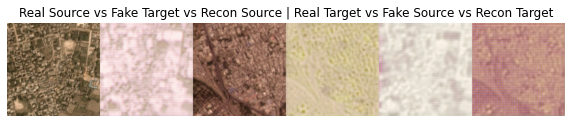

loss source: 0.006250679027289152
loss target: 0.0036379522643983364
loss source: 0.0019013036508113146
loss target: 0.006554491817951202
loss source: 0.010034413076937199
loss target: 0.0024207080714404583
loss source: 0.0018609364051371813
loss target: 0.007024867460131645
loss source: 0.0016731041250750422
loss target: 0.005670001730322838
loss source: 0.003942869137972593
loss target: 0.005439138039946556
loss source: 0.0025754510425031185
loss target: 0.013789808377623558
loss source: 0.005280119366943836
loss target: 0.022776518017053604
loss source: 0.0019991546869277954
loss target: 0.0015414447989314795
loss source: 0.0031839264556765556
loss target: 0.03432668372988701
loss source: 0.0040628984570503235
loss target: 0.002356641460210085
loss source: 0.002031594980508089
loss target: 0.002914218697696924
loss source: 0.00210514385253191
loss target: 0.006896302569657564
loss source: 0.00241357390768826
loss target: 0.002367165172472596
loss source: 0.002050776267424226
loss ta

loss source: 0.0037258751690387726
loss target: 0.0018330622697249055
loss source: 0.002333744429051876
loss target: 0.001294603105634451
loss source: 0.0018122639739885926
loss target: 0.0013687307946383953
loss source: 0.0021512142848223448
loss target: 0.0012097565922886133
loss source: 0.0015658237971365452
loss target: 0.0037599343340843916
loss source: 0.0033351473975926638
loss target: 0.0018652294529601932
loss source: 0.002207805635407567
loss target: 0.0026059173978865147
loss source: 0.0016572559252381325
loss target: 0.0028048146050423384
loss source: 0.0019223563140258193
loss target: 0.0020610077772289515
loss source: 0.004568839445710182
loss target: 0.002409606007859111
loss source: 0.0018612182466313243
loss target: 0.0015760499518364668
loss source: 0.0030549229122698307
loss target: 0.0012016543187201023
loss source: 0.0022134878672659397
loss target: 0.014655313454568386
loss source: 0.004138258285820484
loss target: 0.0042464593425393105
loss source: 0.003524919506

loss source: 0.005411101039499044
loss target: 0.006568149197846651
loss source: 0.0016331408405676484
loss target: 0.009751612320542336
loss source: 0.0014788463013246655
loss target: 0.00174011813942343
loss source: 0.0019388780929148197
loss target: 0.004008688032627106
loss source: 0.004009712021797895
loss target: 0.004325707908719778
loss source: 0.0014949655160307884
loss target: 0.005323030054569244
loss source: 0.002426222199574113
loss target: 0.0031320368871092796
loss source: 0.0027255555614829063
loss target: 0.0024085436016321182
loss source: 0.003962162882089615
loss target: 0.0012513305991888046
loss source: 0.0037771067582070827
loss target: 0.0016357629792764783
loss source: 0.0016268824692815542
loss target: 0.004004438407719135
loss source: 0.0014911616453900933
loss target: 0.01480402797460556
loss source: 0.009101571515202522
loss target: 0.004455946385860443
loss source: 0.0015965066850185394
loss target: 0.002146774437278509
loss source: 0.0014022353570908308
lo

loss source: 0.005202004685997963
loss target: 0.0007410559337586164
loss source: 0.007294436916708946
loss target: 0.0014015606138855219
loss source: 0.0038339735474437475
loss target: 0.0009048078209161758
loss source: 0.0032486352138221264
loss target: 0.0009947331855073571
loss source: 0.005802792496979237
loss target: 0.004355540499091148
loss source: 0.003840430174022913
loss target: 0.0012116284342482686
loss source: 0.0031821499578654766
loss target: 0.0015197222819551826
loss source: 0.0032102027907967567
loss target: 0.0013155865017324686
loss source: 0.003716468345373869
loss target: 0.003911399282515049
loss source: 0.20738394558429718
loss target: 0.0048360018990933895
loss source: 0.003404430579394102
loss target: 0.0033913759980350733
loss source: 0.004510559141635895
loss target: 0.0060781436040997505
loss source: 0.0045633576810359955
loss target: 0.0015388320898637176
loss source: 0.004250433295965195
loss target: 0.0023201594594866037
loss source: 0.00339889689348638

loss source: 0.0013207899173721671
loss target: 0.001675926148891449
loss source: 0.0025107150431722403
loss target: 0.00936045590788126
loss source: 0.005083085037767887
loss target: 0.007603680714964867
loss source: 0.0016269127372652292
loss target: 0.0013121443334966898
loss source: 0.0018744575791060925
loss target: 0.0018703450914472342
loss source: 0.0010903050424531102
loss target: 0.0009837273973971605
loss source: 0.002054584212601185
loss target: 0.005153471603989601
loss source: 0.0018534893169999123
loss target: 0.0014768019318580627
loss source: 0.002086909953504801
loss target: 0.0024663263466209173
loss source: 0.001494050258770585
loss target: 0.0008958718972280622
loss source: 0.001867720391601324
loss target: 0.002149265957996249
loss source: 0.0066841281950473785
loss target: 0.0017804650124162436
loss source: 0.001091749407351017
loss target: 0.0013772291131317616
loss source: 0.001374527346342802
loss target: 0.0007079957285895944
loss source: 0.001545445062220096

loss source: 0.0008177306735888124
loss target: 0.0009849880589172244
loss source: 0.0008845923002809286
loss target: 0.0022036631125956774
loss source: 0.0030531950760632753
loss target: 0.0017056616488844156
loss source: 0.0024395494256168604
loss target: 0.0011861026287078857
loss source: 0.0019534442108124495
loss target: 0.004332554526627064
loss source: 0.002518161665648222
loss target: 0.0008681906620040536
loss source: 0.003266300307586789
loss target: 0.0017836715560406446
loss source: 0.0029916842468082905
loss target: 0.0008998243138194084
loss source: 0.002160092582926154
loss target: 0.0019864572677761316
loss source: 0.0014700035098940134
loss target: 0.004920002073049545
loss source: 0.0016590853920206428
loss target: 0.0016850054962560534
loss source: 0.008750967681407928
loss target: 0.0047376626171171665
loss source: 0.0032268106006085873
loss target: 0.0018396780360490084
loss source: 0.0008771487628109753
loss target: 0.0012566196965053678
loss source: 0.00306170876

loss source: 0.007306349463760853
loss target: 0.002863258821889758
loss source: 0.001535552553832531
loss target: 0.0012243724195286632
loss source: 0.0015866411849856377
loss target: 0.001011580228805542
loss source: 0.0010512752924114466
loss target: 0.0012838930124416947
loss source: 0.0009130937396548688
loss target: 0.000758736627176404
loss source: 0.0012902054004371166
loss target: 0.0016971121076494455
loss source: 0.0008260731119662523
loss target: 0.0007831312832422554
loss source: 0.0015596200246363878
loss target: 0.002245598006993532
loss source: 0.00530998082831502
loss target: 0.0006131255067884922
loss source: 0.002510681049898267
loss target: 0.002291711512953043
loss source: 0.0007598894881084561
loss target: 0.00031536593451164663
loss source: 0.0006579442997463048
loss target: 0.0004558225045911968
loss source: 0.0008432155009359121
loss target: 0.0008434873889200389
loss source: 0.0029162843711674213
loss target: 0.0014776111347600818
loss source: 0.00143781513907

loss source: 0.000836274353787303
loss target: 0.0014778804033994675
loss source: 0.0012176070595160127
loss target: 0.00044996378710493445
loss source: 0.001248165499418974
loss target: 0.009958220645785332
loss source: 0.0013114234898239374
loss target: 0.0012720555532723665
loss source: 0.0013239163672551513
loss target: 0.0011819563806056976
loss source: 0.001512881019152701
loss target: 0.0018959904555231333
loss source: 0.003344553289934993
loss target: 0.0035988849122077227
loss source: 0.0016534633468836546
loss target: 0.001156838028691709
loss source: 0.0014434801414608955
loss target: 0.0013244609581306577
loss source: 0.0009853106457740068
loss target: 0.0016754843527451158
loss source: 0.0016424520872533321
loss target: 0.0006762405391782522
loss source: 0.0033098659478127956
loss target: 0.0024736213963478804
loss source: 0.0015266970731317997
loss target: 0.0008610249496996403
loss source: 0.001302182674407959
loss target: 0.000398344942368567
loss source: 0.001071792561

loss source: 0.005986849777400494
loss target: 0.0008184314356185496
loss source: 0.0052932254038751125
loss target: 0.0010707571636885405
loss source: 0.003054654225707054
loss target: 0.004177884664386511
loss source: 0.001462637446820736
loss target: 0.009408351965248585
loss source: 0.0014590683858841658
loss target: 0.0004664140578825027
loss source: 0.007927380502223969
loss target: 0.0018790573813021183
loss source: 0.0016407027142122388
loss target: 0.006382468622177839
loss source: 0.0016315459506586194
loss target: 0.004280746914446354
loss source: 0.0012041957816109061
loss target: 0.0010467192623764277
loss source: 0.0009584625950083137
loss target: 0.00042518682312220335
loss source: 0.002117941388860345
loss target: 0.0006188351544551551
loss source: 0.002679192926734686
loss target: 0.0007005840889178216
loss source: 0.005977789871394634
loss target: 0.001304082223214209
loss source: 0.001998073421418667
loss target: 0.00249089184217155
loss source: 0.0040106927044689655

loss source: 0.001245215767994523
loss target: 0.0003046861384063959
loss source: 0.001956313382834196
loss target: 0.0012543501798063517
loss source: 0.002326304791495204
loss target: 0.0008937804377637804
loss source: 0.001577821560204029
loss target: 0.054512131959199905
loss source: 0.007183767855167389
loss target: 0.0038302927277982235
loss source: 0.0008924196008592844
loss target: 0.011619788594543934
loss source: 0.05527089536190033
loss target: 0.0022931681014597416
loss source: 0.0007991393795236945
loss target: 0.0011331620626151562
loss source: 0.0019519017077982426
loss target: 0.0010071918368339539
loss source: 0.0014319950714707375
loss target: 0.0023267141077667475
loss source: 0.006376642268151045
loss target: 0.006556881591677666
loss source: 0.001229762681759894
loss target: 0.003570572007447481
loss source: 0.0007291113142855465
loss target: 0.0007052334840409458
loss source: 0.0021535204723477364
loss target: 0.0025765961036086082
loss source: 0.003851357847452163

loss source: 0.0007376285502687097
loss target: 0.001080688089132309
loss source: 0.00320846913382411
loss target: 0.0016253127250820398
loss source: 0.0006264311959967017
loss target: 0.0006997095770202577
loss source: 0.0009137045126408339
loss target: 0.0011933522764593363
loss source: 0.0024842345155775547
loss target: 0.0025654190685600042
loss source: 0.0005087340250611305
loss target: 0.001077868975698948
loss source: 0.000887539703398943
loss target: 0.0019005055073648691
loss source: 0.0010055796010419726
loss target: 0.00417708745226264
loss source: 0.000934187788516283
loss target: 0.0006167731480672956
loss source: 0.0013451959239318967
loss target: 0.001131910947151482
loss source: 0.0008028721786104143
loss target: 0.0038266265764832497
loss source: 0.0008480611722916365
loss target: 0.0007366000209003687
loss source: 0.0008638626895844936
loss target: 0.015967806801199913
loss source: 0.0016817970899865031
loss target: 0.002630106173455715
loss source: 0.0018395949155092

loss source: 0.001060717855580151
loss target: 0.0010890302946791053
loss source: 0.0006707924185320735
loss target: 0.0010069544659927487
loss source: 0.0007625635480508208
loss target: 0.00045588385546579957
loss source: 0.0026012929156422615
loss target: 0.0028225909918546677
loss source: 0.0006561393965967
loss target: 0.0031636320054531097
loss source: 0.0010799332521855831
loss target: 0.00712794903665781
loss source: 0.0011180245783179998
loss target: 0.0007746285991743207
loss source: 0.0006777828675694764
loss target: 0.0008952121715992689
loss source: 0.0009889379143714905
loss target: 0.0006275416817516088
loss source: 0.0008797579212114215
loss target: 0.0021454840898513794
loss source: 0.0014129816554486752
loss target: 0.0018258230993524194
loss source: 0.0010856741573661566
loss target: 0.0004578782245516777
loss source: 0.000914782052859664
loss target: 0.00042423413833603263
loss source: 0.0011568620102480054
loss target: 0.0016212803311645985
loss source: 0.0019522439

loss source: 0.0009694939362816513
loss target: 0.0008060714462772012
loss source: 0.002762244315817952
loss target: 0.00280709657818079
loss source: 0.012516947463154793
loss target: 0.004602278582751751
loss source: 0.0010055634193122387
loss target: 0.007374740205705166
loss source: 0.0007921098731458187
loss target: 0.0010415147989988327
loss source: 0.001013815519399941
loss target: 0.0013058825861662626
loss source: 0.0009833923541009426
loss target: 0.002000915352255106
loss source: 0.0011015444761142135
loss target: 0.0004438800679054111
loss source: 0.0007568680448457599
loss target: 0.004204844124615192
loss source: 0.0011258309241384268
loss target: 0.14292769134044647
loss source: 0.001927628181874752
loss target: 0.006167813669890165
loss source: 0.001325142802670598
loss target: 0.023716788738965988
loss source: 0.0008092945208773017
loss target: 0.02848893590271473
loss source: 0.0007486179820261896
loss target: 0.011617892421782017
loss source: 0.0011959690600633621
los

loss source: 0.0004853222635574639
loss target: 0.0007228212780319154
loss source: 0.0016735111130401492
loss target: 0.0016221834812313318
loss source: 0.001189914532005787
loss target: 0.0018662918591871858
loss source: 0.0011919417884200811
loss target: 0.0012028634082525969
loss source: 0.001867770915850997
loss target: 0.0008388969581574202
loss source: 0.003537895856425166
loss target: 0.0011481207329779863
loss source: 0.0014575968962162733
loss target: 0.004462846089154482
loss source: 0.000923208543099463
loss target: 0.0005195295088924468
loss source: 0.0008491376647725701
loss target: 0.0010901953792199492
loss source: 0.0019941357895731926
loss target: 0.0008038528030738235
loss source: 0.0007016927702352405
loss target: 0.0006608180119656026
loss source: 0.000750390812754631
loss target: 0.0013295140815898776
loss source: 0.0031771042849868536
loss target: 0.0007711558719165623
loss source: 0.000891823903657496
loss target: 0.00045452092308551073
loss source: 0.00215588742

loss source: 0.0007376872235909104
loss target: 0.0011620121076703072
loss source: 0.0013923220103606582
loss target: 0.0005858881049789488
loss source: 0.0009427873301319778
loss target: 0.0009144622017629445
loss source: 0.00056623195996508
loss target: 0.0009666548576205969
loss source: 0.0008119001868180931
loss target: 0.0007181218825280666
loss source: 0.0008749624248594046
loss target: 0.0022006446961313486
loss source: 0.0007582124671898782
loss target: 0.0015374687500298023
loss source: 0.0006823966978117824
loss target: 0.0009710869053378701
loss source: 0.0008715701405890286
loss target: 0.0013423790223896503
loss source: 0.0011939764954149723
loss target: 0.0042586359195411205
loss source: 0.0011885592248290777
loss target: 0.0008186644408851862
loss source: 0.0017146782483905554
loss target: 0.001451688352972269
loss source: 0.001227979315444827
loss target: 0.0014215419068932533
loss source: 0.002220652997493744
loss target: 0.0007190086180344224
loss source: 0.0004882054

loss source: 0.0011569667840376496
loss target: 0.0005136516410857439
loss source: 0.0028113252483308315
loss target: 0.008813821710646152
loss source: 0.0011452153557911515
loss target: 0.0005279768374748528
loss source: 0.0007310452638193965
loss target: 0.0009122409392148256
loss source: 0.0010287273908033967
loss target: 0.001417497405782342
loss source: 0.0006737072835676372
loss target: 0.0006291425670497119
loss source: 0.0006744284182786942
loss target: 0.0006327410228550434
loss source: 0.0007975324988365173
loss target: 0.0005424124537967145
loss source: 0.0005839834921061993
loss target: 0.0002140586730092764
loss source: 0.0005441983230412006
loss target: 0.00028251076582819223
loss source: 0.0007524775573983788
loss target: 0.0004047031397931278
loss source: 0.0006992741255089641
loss target: 0.00023024225083645433
loss source: 0.0006859560962766409
loss target: 0.00029322406044229865
loss source: 0.0028121029026806355
loss target: 0.0013089225394651294
loss source: 0.0015

loss source: 0.004300228785723448
loss target: 0.0008615407859906554
loss source: 0.001465536537580192
loss target: 0.0005130540812388062
loss source: 0.0004661839921027422
loss target: 0.0013313472736626863
loss source: 0.0020711468532681465
loss target: 0.0003028443024959415
loss source: 0.012456617318093777
loss target: 0.0005610028165392578
loss source: 0.0006903918692842126
loss target: 0.0005136248655617237
loss source: 0.0017029878217726946
loss target: 0.0009085481287911534
loss source: 0.00043742655543610454
loss target: 0.0007508244598284364
loss source: 0.0008492607157677412
loss target: 0.0006860316498205066
loss source: 0.0012902981834486127
loss target: 0.0008445106795988977
loss source: 0.001959440065547824
loss target: 0.004068645182996988
loss source: 0.0009390234481543303
loss target: 0.0003631198196671903
loss source: 0.0008029607124626637
loss target: 0.0007428400567732751
loss source: 0.0032802510540932417
loss target: 0.0008621353772468865
loss source: 0.000879059

loss source: 0.001015489106066525
loss target: 0.001825439860112965
loss source: 0.0008113271323964
loss target: 0.0007056116592139006
loss source: 0.0006663617677986622
loss target: 0.0010960359359160066
loss source: 0.0013545677065849304
loss target: 0.000680716650094837
loss source: 0.00043435097904875875
loss target: 0.0004964384716004133
loss source: 0.000767645426094532
loss target: 0.0006532063707709312
loss source: 0.0007377313449978828
loss target: 0.0034884577617049217
loss source: 0.0020356939639896154
loss target: 0.000956836505793035
loss source: 0.0007247896865010262
loss target: 0.000460138515336439
loss source: 0.0005817587953060865
loss target: 0.0002495009684935212
loss source: 0.0004969496512785554
loss target: 0.00044108284055255353
loss source: 0.0008421155507676303
loss target: 0.0006761881522834301
loss source: 0.0071728830225765705
loss target: 0.0020693615078926086
loss source: 0.0015854688826948404
loss target: 0.0009226447436958551
loss source: 0.001632755505

loss source: 0.000582060543820262
loss target: 0.0029577300883829594
loss source: 0.0009556898148730397
loss target: 0.008985164575278759
loss source: 0.0007892872672528028
loss target: 0.0006769110914319754
loss source: 0.000442213291535154
loss target: 0.0004659636178985238
loss source: 0.0003793773357756436
loss target: 0.0003997707972303033
loss source: 0.00045349966967478395
loss target: 0.0006197697948664427
loss source: 0.0004960522055625916
loss target: 0.0003313557244837284
loss source: 0.0011005650740116835
loss target: 0.007852223701775074
loss source: 0.00038606717134825885
loss target: 0.0011348213301971555
loss source: 0.0004956426564604044
loss target: 0.0006619686027988791
loss source: 0.0012202454963698983
loss target: 0.0008388026035390794
loss source: 0.0008534436346963048
loss target: 0.0008732288843020797
loss source: 0.00233597494661808
loss target: 0.0006482973694801331
loss source: 0.0004470988642424345
loss target: 0.00030160066671669483
loss source: 0.00224404

loss source: 0.001035713474266231
loss target: 0.0003374239895492792
loss source: 0.0020272783003747463
loss target: 0.0005548500921577215
loss source: 0.00044498289935290813
loss target: 0.0003994882572442293
loss source: 0.0008853541221469641
loss target: 0.0013630130561068654
loss source: 0.001128448755480349
loss target: 0.0003519505262374878
loss source: 0.0009974546264857054
loss target: 0.00041116942884400487
loss source: 0.0009948520455509424
loss target: 0.0005696671432815492
loss source: 0.0008623077301308513
loss target: 0.0014349439879879355
loss source: 0.001379147870466113
loss target: 0.0010120635852217674
loss source: 0.000939081481192261
loss target: 0.0005160102155059576
loss source: 0.0007285893661901355
loss target: 0.00040491961408406496
loss source: 0.001450209179893136
loss target: 0.0018829216714948416
loss source: 0.00041745640919543803
loss target: 0.00031269757892005146
loss source: 0.0005973981460556388
loss target: 0.0003281505487393588
loss source: 0.00076

loss source: 0.0010012869024649262
loss target: 0.0005235762801021338
loss source: 0.0005139390705153346
loss target: 0.00042580440640449524
loss source: 0.0005224943161010742
loss target: 0.00034208776196464896
loss source: 0.0005702493945136666
loss target: 0.00043600823846645653
loss source: 0.000935596355702728
loss target: 0.0007331215310841799
loss source: 0.00037815619725733995
loss target: 0.0004473045701161027
loss source: 0.0005551411304622889
loss target: 0.0003177392645739019
loss source: 0.0007649540202692151
loss target: 0.000539301719982177
loss source: 0.0006492589018307626
loss target: 0.002119905548170209
loss source: 0.00041241900180466473
loss target: 0.0006501314346678555
loss source: 0.0015865343157202005
loss target: 0.0009683558600954711
loss source: 0.00033475272357463837
loss target: 0.00018293513858225197
loss source: 0.0010720656719058752
loss target: 0.0005918993265368044
loss source: 0.002103459555655718
loss target: 0.000619748723693192
loss source: 0.000

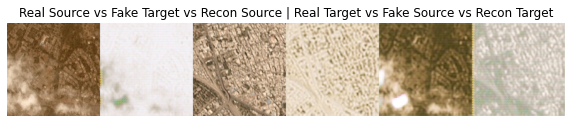

loss source: 0.0017154247034341097
loss target: 0.0006495200796052814
loss source: 0.00040943059138953686
loss target: 0.0007494008168578148
loss source: 0.0003722613619174808
loss target: 0.0002697674499358982
loss source: 0.0021730794105678797
loss target: 0.001244385726749897
loss source: 0.0007145018898881972
loss target: 0.0004996341885998845
loss source: 0.0004191925982013345
loss target: 0.00019943089864682406
loss source: 0.0005270718247629702
loss target: 0.0002944211009889841
loss source: 0.002598418854176998
loss target: 0.002636481309309602
loss source: 0.002113707596436143
loss target: 0.0017694761045277119
loss source: 0.00044987897854298353
loss target: 0.001936545828357339
loss source: 0.002271483652293682
loss target: 0.0008170050568878651
loss source: 0.00038598361425101757
loss target: 0.0003991091507486999
loss source: 0.00044054765021428466
loss target: 0.00016251190390903503
loss source: 0.0006534208077937365
loss target: 0.00021195874433033168
loss source: 0.0005

In [7]:
Tensor  = torch.cuda.FloatTensor
history = {'epoch':[],'G_loss': [], 'D_loss':[], 'cycloss':[],'semloss':[], 'batch':[]}

num_classes = 2
best_gen_loss = 1e6
best_disc_loss = 1e6
n_epochs = 1

for e in range(n_epochs):
    for i, batch in tqdm(enumerate(train_dataloader)):
        
        real_S = batch['D img'].type(Tensor)
        real_T = batch['L img'].type(Tensor)
        real_lbl = batch['D pm'].type(Tensor).float()
          
        #Generator Forward Pass
        G_ST.train()
        G_TS.train()
        
        fake_t         = G_ST(real_S)             #source domain img, styled as target
        fake_s         = G_TS(real_T)             #target domain img, styled as source
        
        recov_s        = G_TS(fake_t)
        recov_t        = G_ST(fake_s)
          
# ---------------------------------------------------------------------------------------------------------
# Run Regressor f_s  L_SEM = Ltask + Ltask;
# ---------------------------------------------------------------------------------------------------------
        set_requires_grad([f_s],requires_grad=False)
        optimizer_f_s.zero_grad()
    
        #Run real img and stylistically transformed img through pretrained network, need 4 instances
        pm_from_real_S  = f_s(real_S).squeeze(1)
        pm_from_fake_T  = f_s(fake_t.detach()).squeeze(1)
        
        pm_from_real_T  = f_s(real_T).squeeze(1)
        pm_from_fake_S  = f_s(fake_s.detach()).squeeze(1)

        #compute MSE from PM values ***predicted*** from real image and fake image (same pm vals tho!!)
        #DO NOT ASSESS WITH REAL PM LABEL, BUT WITH PREDICTION
        
        sem_loss_source    = mseloss(pm_from_real_S, pm_from_fake_T)  #Ltask(fs, G_TS(T), p(fs, T))                   
        sem_loss_targ      = mseloss(pm_from_real_T,pm_from_fake_S)   #Ltask(fs, G_ST(S), p(fs, S))
        sem_loss           = (sem_loss_source + sem_loss_targ)/2
        
#         sem_loss.backward()
        optimizer_f_s.step()
        
# -------------------------------------------------------------------------------------------------------
# Train Generators G_ST and G_TS L_CYC;
# -------------------------------------------------------------------------------------------------------
        set_requires_grad([D_S, D_T],requires_grad=False)
        set_requires_grad([G_ST, G_TS],requires_grad=True)
        optimizer_G.zero_grad()
    
        #****train Generator to produce convincing results to fool D****
        #extra gan loss run not included in objective......
        
        loss_GAN_S, _  = ganloss(D_S(fake_t), True)  #L(D_S(G_ST(S)))             
        loss_GAN_T, _  = ganloss(D_T(fake_s), True)  #L(D_T(G_TS(T)))               
        
        # cycle loss (L1 Loss)      
        loss_cycle_S   = cycleloss(recov_s, real_S)    # Lcyc(G_TS(G_ST(S)), S)
        loss_cycle_T   = cycleloss(recov_t, real_T)    # Lcyc(G_ST(G_TS(T)), T)
        loss_cycle     = loss_cycle_S + loss_cycle_T
        
        
        loss_G = loss_GAN_S + loss_GAN_T + loss_cycle
        
                
        loss_G.backward()
        optimizer_G.step()
        
# -------------------------------------------------------------------------------------------------------
# Train Discriminator S and Discriminator T L_GAN, L_GAN;
# -------------------------------------------------------------------------------------------------------
        set_requires_grad([D_S, D_T],requires_grad=True)
        optimizer_D.zero_grad()
        
        loss_real_s, _ = ganloss(D_S(real_S), True)               
        loss_fake_s, _ = ganloss(D_S(fake_s.detach()), False)   
        
        loss_D_S       = (loss_real_s + loss_fake_s)
        
        loss_real_t, _ = ganloss(D_T(real_T), True)              
        loss_fake_t, _ = ganloss(D_T(fake_t.detach()), False)  
        
        loss_D_T       = (loss_real_t + loss_fake_t)
        loss_D         = (loss_D_S + loss_D_T)

        print(f'loss source: {loss_D_S}\nloss target: {loss_D_T}')
        loss_D.backward()
        optimizer_D.step()
        
        if loss_D < best_disc_loss:
            best_disc_loss = loss_D
            torch.save({ 'D_S': D_S.state_dict(),'D_T': D_T.state_dict()}, 'best_discs.pt')
 
            
        if loss_G < best_gen_loss:
            best_gen_loss = loss_G
            torch.save({ 'G_ST': G_ST.state_dict(),'G_TS': G_TS.state_dict()}, 'best_gens.pt')
            
# ---------------------------------Visualization and Saving---------------------------------      
        
        if (i+1) % 2500 == 0:
            with torch.no_grad():
                sample_images(val_dataloader,e,i,save=True)
                history['G_loss'].append(loss_G.item())
                history['D_loss'].append(loss_D.item())
                history['semloss'].append(sem_loss.item())
                history['cycloss'].append(loss_cycle.item())
                history['batch'].append(i+1)
                history['epoch'].append(e+1)


    now = datetime.datetime.now()
    print(f"Epoch {e + 1}/{n_epochs} finished at {now.time()}\n\
    [G Loss: {loss_G.item()}]\t[D Loss: {loss_D.item()}]\t[Cycle Loss: {loss_cycle.item()}]")

In [12]:
df = pd.DataFrame(history)
df.to_csv('history.csv', index=False)
